In [2]:
# pip install -U langchain-tavily
# https://langchain-ai.github.io/langgraph/tutorials/get-started/2-add-tools/

In [3]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Nodes and Edges | langchain-ai/langgraph-101 | DeepWiki',
   'url': 'https://deepwiki.com/langchain-ai/langgraph-101/2.2-nodes-and-edges',
   'content': 'Nodes and Edges | langchain-ai/langgraph-101 | DeepWiki Nodes and Edges Nodes and Edges What are Nodes and Edges? In LangGraph, a graph is composed of nodes connected by edges to form a directed workflow. Nodes are the workhorses of LangGraph - they are Python functions that receive the current graph state as input, perform operations, and return updates to that state. Edges define the flow of execution between nodes in a LangGraph. graph_builder.add_edge("retrieve_documents", "generate_response") Conditional edges use a function to determine the next node based on the current state. Building a Graph with Nodes and Edges graph_builder.add_node("retrieve_documents", retrieve_documents) graph_builder.add_edge(

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain.chat_models import ChatOpenAI  # from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_tavily import TavilySearch

class State(TypedDict):
    messages: Annotated[list, add_messages]

In [ ]:
# pip show langgraph

Name: langgraph
Version: 0.4.8
Summary: Building stateful, multi-actor applications with LLMs
Home-page: 
Author: 
Author-email: 
License: 
Location: /Users/discovery/.local/lib/python3.12/site-packages
Requires: langchain-core, langgraph-checkpoint, langgraph-prebuilt, langgraph-sdk, pydantic, xxhash
Required-by: langgraph-api, langgraph-runtime-inmem
Note: you may need to restart the kernel to use updated packages.


In [6]:
!python -m langchain_core.sys_info


System Information
------------------
> OS:  Darwin
> OS Version:  Darwin Kernel Version 24.5.0: Tue Apr 22 19:54:26 PDT 2025; root:xnu-11417.121.6~2/RELEASE_ARM64_T8112
> Python Version:  3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:22:19) [Clang 14.0.6 ]

Package Information
-------------------
> langchain_core: 0.3.64
> langchain: 0.3.25
> langchain_community: 0.3.24
> langsmith: 0.3.45
> langchain_chroma: 0.2.4
> langchain_cohere: 0.3.5
> langchain_experimental: 0.3.4
> langchain_huggingface: 0.2.0
> langchain_ollama: 0.3.1
> langchain_openai: 0.2.14
> langchain_tavily: 0.2.3
> langchain_text_splitters: 0.3.8
> langgraph_api: 0.2.37
> langgraph_cli: 0.2.10
> langgraph_license: Installed. No version info available.
> langgraph_runtime: Installed. No version info available.
> langgraph_runtime_inmem: 0.2.0
> langgraph_sdk: 0.1.70

Optional packages not installed
-------------------------------
> langserve

Other Dependencies
------------------
> aiohttp: 3.11.18
> ai

In [7]:
from langchain.chat_models import init_chat_model
llm_with_tools = init_chat_model("openai:gpt-4.1").bind_tools([TavilySearch(max_results=2)])

In [9]:
graph_builder = StateGraph(State)
search_tool = TavilySearch(max_results=2)
tools = [search_tool]

# llm = ChatOpenAI(model="gpt-4o", temperature=0.5).bind_tools(tools)

# llm_with_tools = llm.bind_tools(tools)

llm_with_tools.invoke("What is you name")

AIMessage(content='My name is ChatGPT. How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 771, 'total_tokens': 785, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_51e1070cf2', 'finish_reason': 'stop', 'logprobs': None}, id='run--79061179-3cfe-4782-80ad-8b96c49020cb-0', usage_metadata={'input_tokens': 771, 'output_tokens': 14, 'total_tokens': 785, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [10]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [11]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

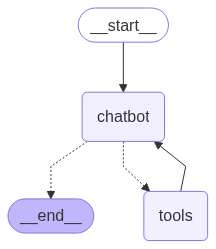

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [13]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    stream_graph_updates(user_input)

Assistant: 
Assistant: {"query": "what is Elon Musk doing today", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://gizmodo.com/elon-musks-xai-is-reportedly-burning-through-1-billion-a-month-2000617458", "title": "Elon Musk\u2019s xAI Is Reportedly Burning Through $1 Billion a Month - Gizmodo", "score": 0.64236575, "published_date": "Wed, 18 Jun 2025 18:10:36 GMT", "content": "By Lucas Ropek Published June 18, 2025 |Comments (15)|\n\n\ud835\udd4f\n\nCopied!\n\nImage 3: Billionaire oligarch Elon Musk at the Conservative Political Action Conference (CPAC) in National Harbor, Maryland, on Feb. 20, 2025.\n\n \u00a9 Jason C. Andrew/Bloomberg via Getty Images [...] Image 4: Elon Musk on May 30, 2025 in the Oval Office of the White House in Washington.Tech News Artificial Intelligence Elon Says He\u2019s Working to \u2018Fix\u2019 Grok After AI Disagrees With Him on Right-Wing Violence ----------------------------------------------------------------------

In [14]:
# Memory

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [15]:
graph = graph_builder.compile(checkpointer=memory)

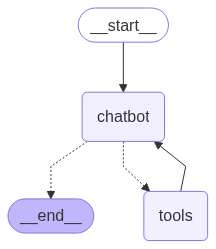

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [18]:
config = {"configurable": {"thread_id": "1"}}

In [19]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hi Will! Nice to meet you. How can I help you today?


In [20]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, your name is Will! If there’s anything else you’d like me to remember or help with, just let me know.


In [21]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I don’t actually have access to your name yet! If you’d like, you can tell me your name, and I’ll remember it for this conversation. Would you like to share it?


In [22]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='a626e91a-0112-41fd-94b1-35e58f77ff90'), AIMessage(content='Hi Will! Nice to meet you. How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 775, 'total_tokens': 791, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_51e1070cf2', 'finish_reason': 'stop', 'logprobs': None}, id='run--2df821f4-5395-45ae-80bf-59df922fd1f7-0', usage_metadata={'input_tokens': 775, 'output_tokens': 16, 'total_tokens': 791, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='Remember my name?', additi